# UUZOP projekt
# Priprema i vizualizacija podataka
Kroz ovu bilježnicu ćemo proći kroz prvi dio projekta iz predmeta Uvod o znanost o podacima. U ovom dijelu projekta radimo na pripremi i vizualizaciji podataka vezanih za američku studentsku košarkašku ligu te turnire koji se igraju na kraju sezone.

In [433]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif

Učitajmo najprije podatke u bilježnicu i pregledajmo što smo učitali. 

In [399]:
teams = pd.read_csv("./Projekt/data/teams.csv")
seasons = pd.read_csv("./Projekt/data/seasons.csv")
season_results = pd.read_csv("./Projekt/data/regular_season_results.csv")
tourney_results = pd.read_csv("./Projekt/data/tourney_results.csv")
tourney_seeds = pd.read_csv("./Projekt/data/tourney_seeds.csv")
tourney_slots = pd.read_csv("./Projekt/data/tourney_slots.csv")

print('(teams rows, teams columns) -> ', teams.shape)
print('(seasons rows, seasons columns) -> ', seasons.shape)
print('(season_results rows, season_results columns) -> ', season_results.shape)
print('(tourney_results rows, tourney_results columns) -> ', tourney_results.shape)
print('(tourney_seeds rows, tourney_seeds columns) -> ', tourney_seeds.shape)
print('(tourney_slots rows, tourney_slots columns) -> ', tourney_slots.shape)

(teams rows, teams columns) ->  (356, 2)
(seasons rows, seasons columns) ->  (19, 7)
(season_results rows, season_results columns) ->  (91224, 8)
(tourney_results rows, tourney_results columns) ->  (1156, 7)
(tourney_seeds rows, tourney_seeds columns) ->  (1242, 3)
(tourney_slots rows, tourney_slots columns) ->  (1223, 4)


In [400]:
teams.head()

,id,name
0,501,Abilene Chr
1,502,Air Force
2,503,Akron
3,504,Alabama
4,505,Alabama A&M


In [401]:
seasons.head()

,season,years,dayzero,regionW,regionX,regionY,regionZ
0,A,1995-1996,10/30/1995,East,Midwest,Southeast,West
1,B,1996-1997,10/28/1996,East,Southeast,Midwest,West
2,C,1997-1998,10/27/1997,East,West,Midwest,South
3,D,1998-1999,10/26/1998,East,Midwest,South,West
4,E,1999-2000,11/01/1999,Midwest,West,East,South


In [402]:
season_results.head()

,season,daynum,wteam,wscore,lteam,lscore,wloc,numot
0,A,16,511,91,647,57,H,NaN
1,A,16,515,75,812,67,H,NaN
2,A,16,606,87,658,67,H,NaN
3,A,16,670,73,573,65,H,NaN
4,A,16,721,99,632,68,H,NaN


In [403]:
tourney_results.head()

,season,daynum,wteam,wscore,lteam,lscore,numot
0,A,136,515,86,729,80,NaN
1,A,136,559,68,555,59,NaN
2,A,136,576,75,666,63,NaN
3,A,136,581,75,577,60,NaN
4,A,136,604,81,551,74,NaN


In [404]:
tourney_seeds.head()

,season,seed,team
0,A,W01,663
1,A,W02,603
2,A,W03,796
3,A,W04,660
4,A,W05,729


In [405]:
tourney_slots.head()

,season,slot,strongseed,weakseed
0,A,R1W1,W01,W16
1,A,R1W2,W02,W15
2,A,R1W3,W03,W14
3,A,R1W4,W04,W13
4,A,R1W5,W05,W12


# season_results
Pogledajmo najprije tablicu season_results. Tablica ima 91224 zapisa (svaki predstavlja jednu utakmicu u određenoj sezoni) i 8 značajki.

In [406]:
print('(season_results rows, season_results columns) -> ', season_results.shape)
season_results

(season_results rows, season_results columns) ->  (91224, 8)


,season,daynum,wteam,wscore,lteam,lscore,wloc,numot
0,A,16,511,91,647,57,H,NaN
1,A,16,515,75,812,67,H,NaN
2,A,16,606,87,658,67,H,NaN
3,A,16,670,73,573,65,H,NaN
4,A,16,721,99,632,68,H,NaN
...,...,...,...,...,...,...,...,...
91219,S,132,592,61,640,60,N,0.0
91220,S,132,671,69,670,55,N,0.0
91221,S,132,779,65,825,61,N,0.0
91222,S,132,811,82,605,81,N,1.0


Pogledajmo sada sadrži li ova tablica nedostajajuće podatke i postoje li stršeće vrijednosti.

In [407]:
season_results.isna().sum()

season        0
daynum        0
wteam         0
wscore        0
lteam         0
lscore        0
wloc          0
numot     39891
dtype: int64

Značajka **numot** sadrži više od trećine nedostajajućih podataka. Smatram da nam za našu predikciju ova značajka nije od prevelike važnosti stoga ćemo ju obrisati.

In [408]:
season_results.drop(['numot'], axis=1, inplace=True)
season_results.isna().sum()

season    0
daynum    0
wteam     0
wscore    0
lteam     0
lscore    0
wloc      0
dtype: int64

Pogledajmo sadrži li tablica neke stršeće vrijednosti.

In [409]:
season_results_tmp.describe()

,season,daynum,wteam,wscore,lteam,lscore,wloc
count,91224.000000,91224.000000,91224.000000,91224.000000,91224.000000,91224.000000,91224.000000
mean,9.454376,73.410133,680.981058,75.370440,677.047400,63.208860,0.788729
std,5.448074,34.210997,103.099502,11.408528,102.950054,10.940295,0.594686
min,0.000000,0.000000,501.000000,34.000000,501.000000,20.000000,0.000000
25%,5.000000,44.000000,592.000000,68.000000,587.000000,56.000000,0.000000
50%,10.000000,75.000000,678.000000,75.000000,675.000000,63.000000,1.000000
75%,14.000000,103.000000,772.000000,83.000000,768.000000,70.000000,1.000000
max,18.000000,133.000000,856.000000,153.000000,856.000000,140.000000,2.000000


Vidimo da su kandidati za stršeču vrijednost **wscore** i **lscore**. Maksimalne vrijednosti im dosta odskaču, ali nisu nemoguće. Promijenimo značajku wloc u numeričku vrijednost koristeći LabelEncoder. Broj 1 predstavlja domaći teren, broj 0 gostujući, a broj 2 neutralni. Prikažimo broj pobjeđenh utakmica u ovisnosti o terenu. Vidimo da je ostvareno duplo više pobjeda na domaćem terenu nego na gostujućem.

In [410]:
le = LabelEncoder()
le.fit(season_results.loc[:,'wloc'])
season_results.loc[:,'wloc'] = le.transform(season_results.loc[:,'wloc'])

season_results[['wloc','wscore']].groupby('wloc').count()

C:\Users\PC\AppData\Local\Temp\ipykernel_11308\3154691054.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  season_results.loc[:,'wloc'] = le.transform(season_results.loc[:,'wloc'])


,wscore
wloc,
0,27803
1,54891
2,8530


Promijenimo zatim značajku **season** u brojčanu vrijednost, isto koristeći LabelEncoder. Atribut season se pojavljuje u čak pet tablica, tako da ćemo ga odmah pretvoriti u brojčanu vrijednost u svih pet tablica.

In [411]:
le = LabelEncoder()

le.fit(season_results.loc[:,'season'])
season_results.loc[:,'season'] = le.transform(season_results.loc[:,'season'])

le.fit(seasons.loc[:,'season'])
seasons.loc[:,'season'] = le.transform(seasons.loc[:,'season'])

le.fit(tourney_results.loc[:,'season'])
tourney_results.loc[:,'season'] = le.transform(tourney_results.loc[:,'season'])

le.fit(tourney_seeds.loc[:,'season'])
tourney_seeds.loc[:,'season'] = le.transform(tourney_seeds.loc[:,'season'])

le.fit(tourney_slots.loc[:,'season'])
tourney_slots.loc[:,'season'] = le.transform(tourney_slots.loc[:,'season'])


C:\Users\PC\AppData\Local\Temp\ipykernel_11308\1335270236.py:4: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  season_results.loc[:,'season'] = le.transform(season_results.loc[:,'season'])
C:\Users\PC\AppData\Local\Temp\ipykernel_11308\1335270236.py:7: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  seasons.loc[:,'season'] = le.transform(seasons.loc[:,'season'])
C:\Users\PC\AppData\Local\Temp\ipykernel_11308\1335270236.py:10: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a 

Prikažimo sada neke zanimljivosti iz ove tablice grafički. Donji grafovi prikazuju koliko se najviše koševa zabilo u jednoj utakmici po sezonama, dok graf ispod pokazuje koliko se najmanje koševa u jednoj utakmici zabilo po sezonama.

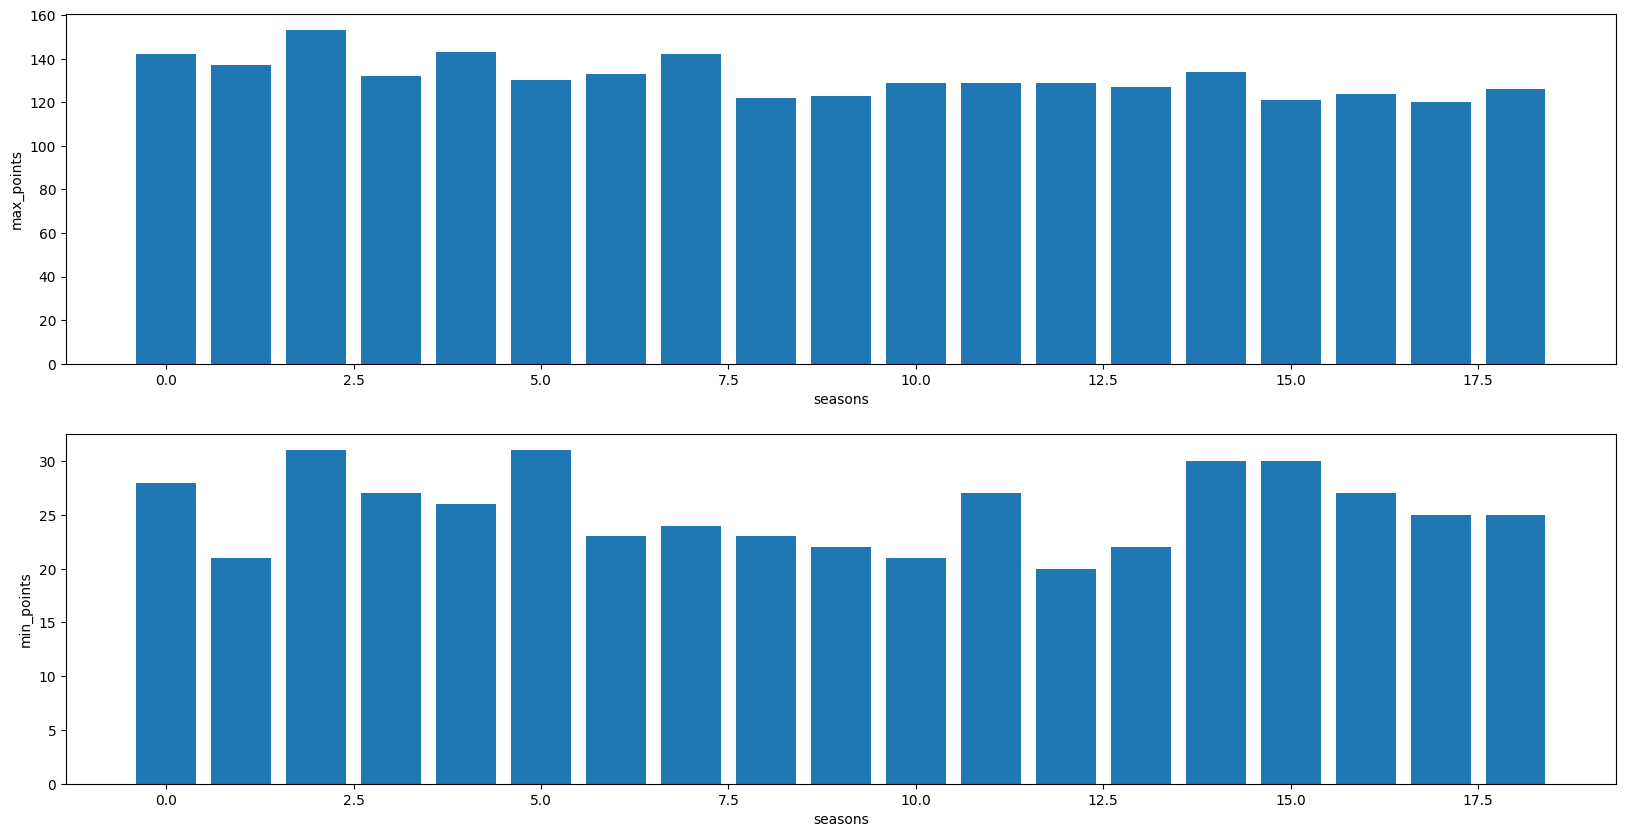

In [494]:
max_points = season_results.groupby(['season'], as_index=False)['wscore'].max()
min_points = season_results.groupby(['season'], as_index=False)['lscore'].min()

fig, ax = plt.subplots(2,1, figsize=(20,10)) 
ax[0].bar(max_points.season,max_points.wscore)
ax[0].set_xlabel('seasons')
ax[0].set_ylabel('max_points')

ax[1].bar(min_points.season,min_points.lscore)
ax[1].set_xlabel('seasons')
ax[1].set_ylabel('min_points')

plt.show()

Donji graf prikazuje prosječan broj koševa od strane pobjedničkih ekipa po sezonama.

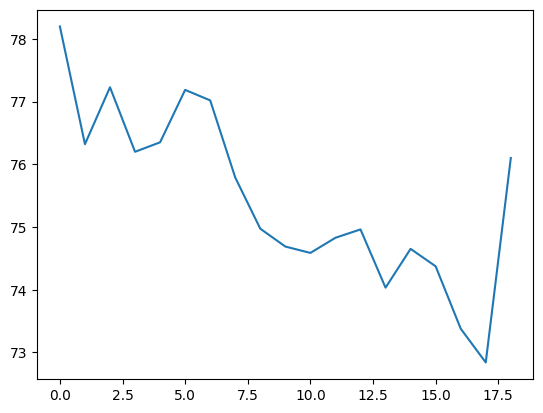

In [503]:
avg_win_points = season_results.groupby(['season'], as_index=False)['wscore'].mean()

plt.plot(avg_win_points.season, avg_win_points.wscore)
plt.show()

Donji graf prikazuje koliko znači prednost domaćeg terena. Vidimo da ekipe puno više pobjeda imaju na domaćem terenu nego na gostujućem ili neutralnom terenu.

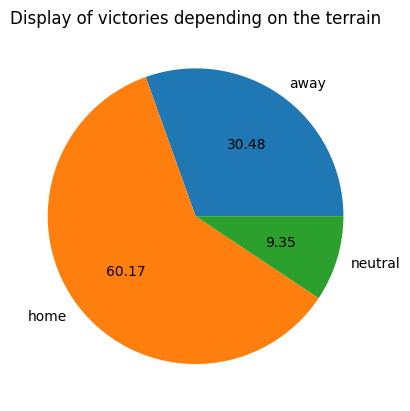

In [650]:
count_per_loc = season_results.groupby('wloc').count().loc[:, 'season'].values

plt.pie(count_per_loc, labels=['away', 'home', 'neutral'], autopct='%.2f')
plt.title('Display of victories depending on the terrain')
plt.show()

# tourney_results
Pogledajmo sada tablicu tourney_results. Tablica ima 1156 redaka i 7 značajki. Pogledajmo nedostajajuće podatke.

In [412]:
print('(rows, attributes) ->',tourney_results.shape)
tourney_results

(rows, attributes) -> (1156, 7)


,season,daynum,wteam,wscore,lteam,lscore,numot
0,0,136,515,86,729,80,NaN
1,0,136,559,68,555,59,NaN
2,0,136,576,75,666,63,NaN
3,0,136,581,75,577,60,NaN
4,0,136,604,81,551,74,NaN
...,...,...,...,...,...,...,...
1151,17,146,651,85,577,63,0.0
1152,17,146,670,79,592,59,0.0
1153,17,152,651,72,846,68,0.0
1154,17,152,670,61,786,56,0.0


In [413]:
tourney_results.isna().sum()

season      0
daynum      0
wteam       0
wscore      0
lteam       0
lscore      0
numot     571
dtype: int64

Vidimo da za 50% n-torki ne postoji vrijednost **numot**. Ovih nedostajajućih vrijednosti ćemo se riješiti tako da uklonimo značajku numot iz skupa podataka, kao što smo napravili i u season_results.

In [414]:
tourney_results.drop(['numot'], axis=1, inplace=True)
tourney_results.isna().sum()

season    0
daynum    0
wteam     0
wscore    0
lteam     0
lscore    0
dtype: int64

Pogledajmo sada postoje li stršeće vrijednosti u tablici tourney_results.

In [415]:
tourney_results.describe()

,season,daynum,wteam,wscore,lteam,lscore
count,1156.000000,1156.000000,1156.000000,1156.000000,1156.000000,1156.000000
mean,8.586505,139.143599,682.515571,75.549308,686.699827,63.667820
std,5.204922,4.213580,98.684397,10.941410,103.201450,10.567058
min,0.000000,134.000000,504.000000,43.000000,502.000000,29.000000
25%,4.000000,136.000000,606.000000,68.000000,603.750000,57.000000
50%,9.000000,137.000000,671.000000,75.000000,681.500000,63.000000
75%,13.000000,139.000000,783.000000,82.000000,783.000000,70.000000
max,17.000000,154.000000,853.000000,121.000000,853.000000,105.000000


U ovom skupu podataka za sad ne mogu uočiti nikakve stršeće vrijednosti. Nema potrebe za reformatiranjem značajki jer su sve značajke brojčane vrijednosti. Vizualizirajmo malo podatke. Donji graf prikazuje top 10 timova sa najviše pobjeda(prvi graf) i s najviše poraza(drugi graf).

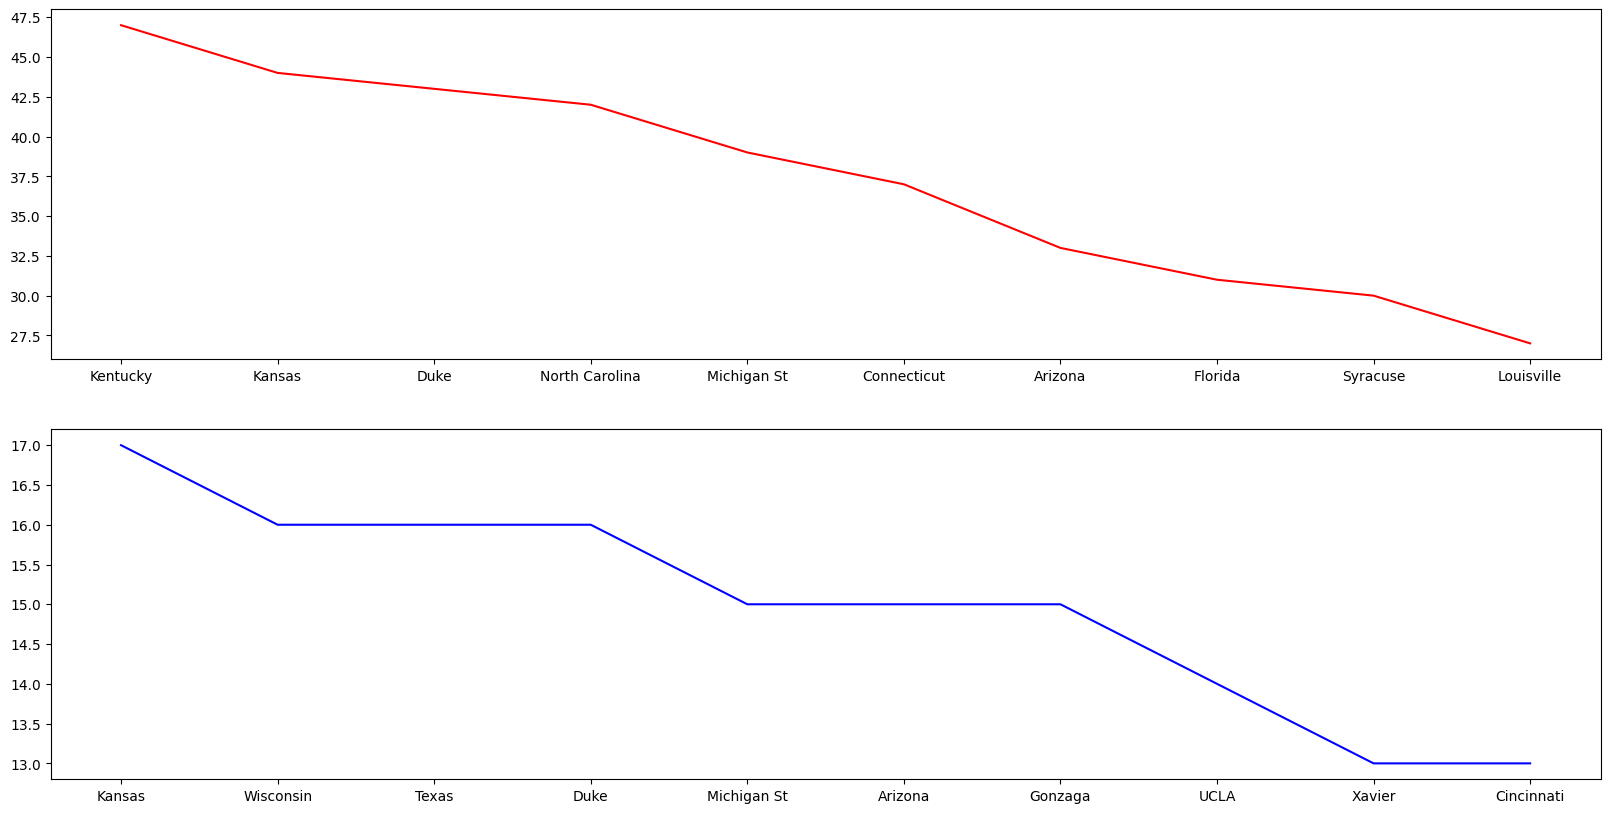

In [637]:
wining_teams = tourney_results.merge(teams, left_on='wteam', right_on='id')
wining_teams = wining_teams.groupby('name', as_index=False)['daynum'].count().sort_values(by='daynum', ascending=False).head(10)

losing_teams = tourney_results.merge(teams, left_on='lteam', right_on='id')
losing_teams = losing_teams.groupby('name', as_index=False)['daynum'].count().sort_values(by='daynum', ascending=False).head(10)

fig, ax = plt.subplots(2,1, figsize=(20,10)) 
ax[0].plot(wining_teams.name, wining_teams.daynum, c='r')
ax[1].plot(losing_teams.name, losing_teams.daynum, c='b')

plt.show()

# seasons
Pogledajmo tablicu seasons. Tablica ima 19 zapisa (svaki predstavlja jednu sezonu) i 7 značajki.

In [416]:
print('(seasons rows, seasons columns) -> ', seasons.shape)
seasons

(seasons rows, seasons columns) ->  (19, 7)


,season,years,dayzero,regionW,regionX,regionY,regionZ
0,0,1995-1996,10/30/1995,East,Midwest,Southeast,West
1,1,1996-1997,10/28/1996,East,Southeast,Midwest,West
2,2,1997-1998,10/27/1997,East,West,Midwest,South
3,3,1998-1999,10/26/1998,East,Midwest,South,West
4,4,1999-2000,11/01/1999,Midwest,West,East,South
5,5,2000-2001,10/30/2000,East,West,Midwest,South
6,6,2001-2002,10/29/2001,East,Midwest,South,West
7,7,2002-2003,11/04/2002,East,South,Midwest,West
8,8,2003-2004,11/03/2003,Atlanta,Phoenix,EastRutherford,StLouis
9,9,2004-2005,11/01/2004,Albuquerque,Chicago,Austin,Syracuse


Bilo bi dobro promijeniti format značajke **years**. Stvorit ćemo novu značajku **begining_year** koja će predstavljati godinu u kojoj je sezona počela.

In [417]:
new = seasons['years'].str.split('-', n = 1, expand = True)
seasons['begining_year'] = pd.to_numeric(new[0])
seasons.drop(['years'], axis=1, inplace=True)
seasons


,season,dayzero,regionW,regionX,regionY,regionZ,begining_year
0,0,10/30/1995,East,Midwest,Southeast,West,1995
1,1,10/28/1996,East,Southeast,Midwest,West,1996
2,2,10/27/1997,East,West,Midwest,South,1997
3,3,10/26/1998,East,Midwest,South,West,1998
4,4,11/01/1999,Midwest,West,East,South,1999
5,5,10/30/2000,East,West,Midwest,South,2000
6,6,10/29/2001,East,Midwest,South,West,2001
7,7,11/04/2002,East,South,Midwest,West,2002
8,8,11/03/2003,Atlanta,Phoenix,EastRutherford,StLouis,2003
9,9,11/01/2004,Albuquerque,Chicago,Austin,Syracuse,2004


Dodajmo sada regije kao značajke. Svaki zapis za svaku regiju promijenit ćemo u brojčanu vrijednost koristeći labelEncoder. Prvotne regije u tekstualnom obliku ćemo ostaviti još neko vrijeme, možda nam zatrebaju.

In [418]:
seasons_tmp = seasons.copy()
regions = pd.concat([seasons_tmp.loc[:, 'regionW'], 
                     seasons_tmp.loc[:, 'regionX'], 
                     seasons_tmp.loc[:, 'regionY'], 
                     seasons_tmp.loc[:, 'regionZ']]).drop_duplicates()
le = LabelEncoder()
le.fit(regions)

seasons_tmp['regionW_num'] = le.transform(seasons_tmp.loc[:,'regionW'])
seasons_tmp['regionX_num'] = le.transform(seasons_tmp.loc[:,'regionX'])
seasons_tmp['regionY_num'] = le.transform(seasons_tmp.loc[:,'regionY'])
seasons_tmp['regionZ_num'] = le.transform(seasons_tmp.loc[:,'regionZ'])

seasons = seasons_tmp.copy()
seasons


,season,dayzero,regionW,regionX,regionY,regionZ,begining_year,regionW_num,regionX_num,regionY_num,regionZ_num
0,0,10/30/1995,East,Midwest,Southeast,West,1995,4,6,11,16
1,1,10/28/1996,East,Southeast,Midwest,West,1996,4,11,6,16
2,2,10/27/1997,East,West,Midwest,South,1997,4,16,6,10
3,3,10/26/1998,East,Midwest,South,West,1998,4,6,10,16
4,4,11/01/1999,Midwest,West,East,South,1999,6,16,4,10
5,5,10/30/2000,East,West,Midwest,South,2000,4,16,6,10
6,6,10/29/2001,East,Midwest,South,West,2001,4,6,10,16
7,7,11/04/2002,East,South,Midwest,West,2002,4,10,6,16
8,8,11/03/2003,Atlanta,Phoenix,EastRutherford,StLouis,2003,1,9,5,13
9,9,11/01/2004,Albuquerque,Chicago,Austin,Syracuse,2004,0,3,2,14


Pogledajmo sada sadrži li ova tablica nedostajajuće podatke i postoje li stršeće vrijednosti.

In [419]:
seasons.isna().sum()

season           0
dayzero          0
regionW          0
regionX          0
regionY          0
regionZ          0
begining_year    0
regionW_num      0
regionX_num      0
regionY_num      0
regionZ_num      0
dtype: int64

In [420]:
seasons.describe()

,season,begining_year,regionW_num,regionX_num,regionY_num,regionZ_num
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,9.000000,2004.000000,3.578947,9.736842,7.052632,14.526316
std,5.627314,5.627314,1.387075,3.927709,2.527047,2.318247
min,0.000000,1995.000000,0.000000,3.000000,2.000000,10.000000
25%,4.500000,1999.500000,4.000000,6.000000,6.000000,13.500000
50%,9.000000,2004.000000,4.000000,10.000000,6.000000,16.000000
75%,13.500000,2008.500000,4.000000,10.500000,10.000000,16.000000
max,18.000000,2013.000000,6.000000,16.000000,11.000000,16.000000


Nedostajajući podaci ne postoje, a stršeće vrijednosti ne mogu pronaći. Pokušajmo vizualizirati podatke iz tablice. Na primjer, tablica ispod prikazuje koliko je puta koja regija sudjelovala u finalnom turniru na kraju sezone.

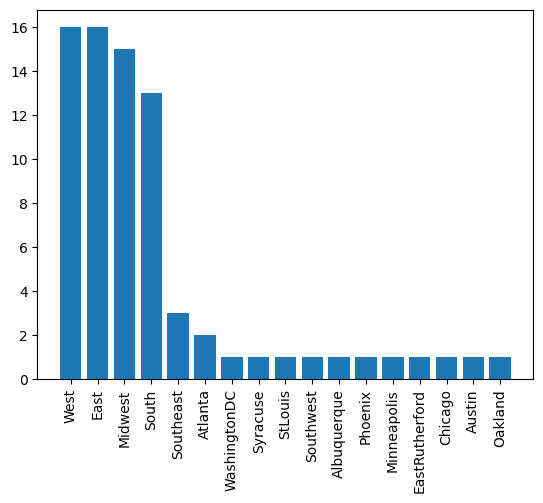

In [622]:
tmp = pd.concat([seasons['regionW'], seasons['regionX'], seasons['regionY'], seasons['regionZ']])

tmp = tmp.to_frame().rename(columns={0:'region'})
tmp['rand'] = 1
tmp = tmp.groupby('region', as_index=False)['rand'].count().sort_values(by='rand', ascending=False)

plt.bar(tmp.region, tmp.rand)
plt.xticks(rotation=90)
plt.show()

# tourney_seeds
Pogledajmo sada tablicu tourney_seeds. Tablica ima 1242 zapisa i 3 značajke.

In [421]:
print('(tourney_seeds rows, tourney_seeds columns) -> ', tourney_seeds.shape)
tourney_seeds

(tourney_seeds rows, tourney_seeds columns) ->  (1242, 3)


,season,seed,team
0,0,W01,663
1,0,W02,603
2,0,W03,796
3,0,W04,660
4,0,W05,729
...,...,...,...
1237,18,Z12,689
1238,18,Z13,702
1239,18,Z14,811
1240,18,Z15,509


Pogledajmo postoji li nedostajajućih podataka ili stršećih vrijednosti.

In [422]:
tourney_seeds.isna().sum()

season    0
seed      0
team      0
dtype: int64

In [423]:
tourney_seeds.describe()

,season,team
count,1242.000000,1242.000000
mean,9.100644,685.844605
std,5.495029,103.133122
min,0.000000,502.000000
25%,4.000000,603.000000
50%,9.000000,680.000000
75%,14.000000,783.000000
max,18.000000,853.000000


Nedostajajućih i stršećih vrijednosti očekivano nema. Pogledajmo značajku **seed**. Pokušajmo ju drukčije formatirati i od nje napraviti dvije značajke: prva neka se zove **region**, a druga neka bude **seed_in_region**. Značajku region dobit ćemo uzimanjem prvog slova značajke seed (0->W, 1->X, 2->Y, 3->Z), a seed_in_region dobivamo kao ostatak značajke seed (na nekoliko mjesta postojalo je sed_in_region = '16a' ili '16b', pretpostavljam da su te ekipe imale isti broj bodova pa su obje bile na 16. mjestu, zanemario sam taj podatak tako da bih dobio značajku seed_in_region kao numeričku vrijednost)

In [424]:
tourney_seeds['region'] = tourney_seeds['seed'].astype(str).str[0]
tourney_seeds['seed_in_region'] = tourney_seeds['seed'].astype(str).str[1:]
exceptions = tourney_seeds.loc[(tourney_seeds.seed_in_region.str.contains('a', regex=False)) |
                  (tourney_seeds.seed_in_region.str.contains('b', regex=False)), 'seed_in_region']
exceptions = exceptions.str[:-1]
tourney_seeds.loc[(tourney_seeds.seed_in_region.str.contains('a', regex=False)) |
                  (tourney_seeds.seed_in_region.str.contains('b', regex=False)), 'seed_in_region'] = exceptions

tourney_seeds['seed_in_region'] = pd.to_numeric(tourney_seeds['seed_in_region'])

le = LabelEncoder()
le.fit(tourney_seeds.loc[:,'region'])
tourney_seeds.loc[:,'region'] = le.transform(tourney_seeds.loc[:,'region'])


tourney_seeds.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242 entries, 0 to 1241
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   season          1242 non-null   int32 
 1   seed            1242 non-null   object
 2   team            1242 non-null   int64 
 3   region          1242 non-null   int32 
 4   seed_in_region  1242 non-null   int64 
dtypes: int32(2), int64(2), object(1)
memory usage: 38.9+ KB


C:\Users\PC\AppData\Local\Temp\ipykernel_11308\3598595428.py:13: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  tourney_seeds.loc[:,'region'] = le.transform(tourney_seeds.loc[:,'region'])


In [425]:
tourney_seeds.drop(['seed'], axis=1, inplace=True)
tourney_seeds

,season,team,region,seed_in_region
0,0,663,0,1
1,0,603,0,2
2,0,796,0,3
3,0,660,0,4
4,0,729,0,5
...,...,...,...,...
1237,18,689,3,12
1238,18,702,3,13
1239,18,811,3,14
1240,18,509,3,15


# tourney_slots
Pogledajmo sada tablicu tourney_slots. Tablica ima 1223 zapisa i 4 značajke.

In [426]:
print('(tourney_slots rows, tourney_slots columns) -> ', tourney_slots.shape)
tourney_slots

(tourney_slots rows, tourney_slots columns) ->  (1223, 4)


,season,slot,strongseed,weakseed
0,0,R1W1,W01,W16
1,0,R1W2,W02,W15
2,0,R1W3,W03,W14
3,0,R1W4,W04,W13
4,0,R1W5,W05,W12
...,...,...,...,...
1218,18,R4Y1,R3Y1,R3Y2
1219,18,R4Z1,R3Z1,R3Z2
1220,18,R5WX,R4W1,R4X1
1221,18,R5YZ,R4Y1,R4Z1


Pogledajmo postoji li nedostajajućih podataka ili stršećih vrijednosti, te koji su tipovi podataka u tablici.

In [427]:
tourney_slots.isna().sum()

season        0
slot          0
strongseed    0
weakseed      0
dtype: int64

In [428]:
tourney_slots.describe()

,season
count,1223.000000
mean,9.102208
std,5.495291
min,0.000000
25%,4.000000
50%,9.000000
75%,14.000000
max,18.000000


In [429]:
tourney_slots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1223 entries, 0 to 1222
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   season      1223 non-null   int32 
 1   slot        1223 non-null   object
 2   strongseed  1223 non-null   object
 3   weakseed    1223 non-null   object
dtypes: int32(1), object(3)
memory usage: 33.6+ KB


Nedostajajućih i stršećih vrijednosti očekivano nema. Većina podataka u tablici su tipa object. U ovoj tablici nisam mijenjao format značajki jer trenutno nisam siguran na koji način prikazati ove značajke numerički, a da mi posluži u kasnijem radu na projektu. 